# Power System Expansion Optimization Model 2.2
* Author: Xin Chen 
* Created on [08/12/2022]
* Decisions: 
1- Site & size of renewables and storage;
2- Retirement of conventional generators;

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

* Modified on [8/28/2022] 
* Implementation delicated to ERCOT system

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

* Modified on [9/2/2022]
* To speedup the solution, reduce the storage model to be 100% charging/discharging efficiency
* Consider no load shedding

* Modified on [9/6/2022]
* Use all locations to install solar, wind, and storage

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

* Modified on [9/9/2022]
* Cluster all days into K typical days, and plan optimization based on these days

In [1]:
using JuMP, PowerModels, Gurobi, Plots,  CSV, DataFrames, LinearAlgebra, TickTock #Gurobi,  Ipopt,CPLEX,

# 1 - Read Power Grid Info From CSV Files

Total bus number is 2000
Total time number is 8784


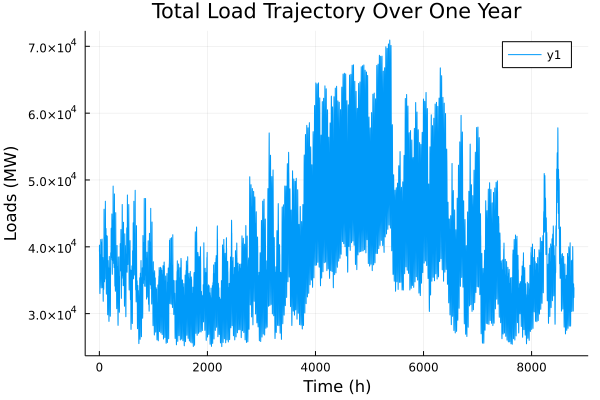

Total branch number is 3206

In [3]:
# Total simulation time steps 
num_time_sim = 24 # total: 8784
dt = 2  # hour resolution
time_ini = 5375-17 #  
T_sim = time_ini:dt:(time_ini + dt*num_time_sim - 1)

# renewable penetration ratio
renew_pene = 80
gam_P = renew_pene/(1-renew_pene);
gam_C = renew_pene/(1-renew_pene);

# ------------------ Buses ---------------------
bus_data = DataFrame(CSV.File("ERCOTSystem\\texas_bus.csv"))
num_bus = size(bus_data, 1)
bus_data.rowindex = 1:num_bus  # add a row order index
print("Total bus number is ", num_bus, "\n")

# ------------------ Loads ------------------
# (net load of nodal hydro generation)
load_data = DataFrame(CSV.File("ERCOTSystem\\loads.csv"))
timeslots = load_data[!,"UTC Time"]
num_time = size(load_data,1)
num_load = size(load_data,2) - 1
print("Total time number is ", num_time, "\n")

# 1 - direct from load csv that arrange load in the order of bus
p_load_t_all = Matrix(load_data[:,2:end])'/100    # unit: MW
p_load_t = p_load_t_all[:, T_sim]
# A_load = Matrix(1I, num_load, num_load)

# # 2 - rigerous way to get load matrices (I have checked these two ways give the same matrices)
# p_load_t = zeros(num_load,num_time)  # time-varying load
# A_load = zeros(num_bus, num_load)
# for i = 1:num_load
#     p_load_t[i,:] = Array(load_data[:, i+1])'/100
#     bus_load = bus_data[ bus_data.bus_id .== parse(Int64, names(load_data)[i+1]), :].rowindex
#     A_load[bus_load, i] .= 1
# end

p_load_max_t = abs.(p_load_t);
p_load_min_t = 0.8*p_load_max_t;

# total load over time
total_load_t = sum(p_load_t_all, dims=1)

# Load Shedding 
ratio_shed_t = 0.2 
ratio_shed_all = 0.2
L_shed_max_t = ratio_shed_t*total_load_t
L_shed_max = ratio_shed_all*sum(total_load_t)

#plot load trajectories
L1 = plot(total_load_t', xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Total Load Trajectory Over One Year")
display(L1)
# ------------------ Branch ------------------
branch_data = DataFrame(CSV.File("ERCOTSystem\\texas_branch.csv"))
num_branch = size(branch_data, 1)
print("Total branch number is ", num_branch)

# construct key branch matrices 
A_nb = zeros(num_bus, num_branch); #node-branch incidence matrix
X_bn = zeros(num_branch, num_bus)  #branch-node resistance matrix
P_br_max = zeros(num_branch, num_time_sim);  # branch transmission capacity
for i = 1:num_branch
    P_br_max[i,:] = (branch_data[i,:].rateA + branch_data[i,:].rateB + branch_data[i,:].rateC)*ones(1,num_time_sim);
    
    f_bus_id = branch_data[i,:].from_bus_id
    t_bus_id = branch_data[i,:].to_bus_id
    f_bus = bus_data[bus_data.bus_id .== f_bus_id, :].rowindex
    t_bus = bus_data[bus_data.bus_id .== t_bus_id, :].rowindex
    
    if length(f_bus)>=2 || length(t_bus)>=2
        print("Error in bus selection!") # in case of getting multiple buses
    end
    
    x_br  = branch_data[i,:].x
    
    X_bn[i, f_bus] .=  1/x_br
    X_bn[i, t_bus] .= -1/x_br
    A_nb[f_bus, i] .=  1 
    A_nb[t_bus, i] .= -1 
end

P_br_min = - P_br_max;

Load Peak: 70936.79000000001(MW) at 2016-08-11 22:00:00
Time Index: 5375

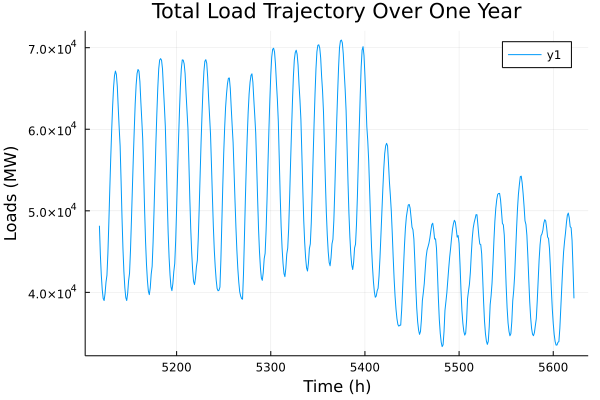

In [18]:
# Load trajectory around load peak
# Load Peak Time
max_L_index = findfirst(x -> x == maximum(total_load_t), total_load_t)[2]
print("Load Peak: ", maximum(total_load_t), "(MW) at ", timeslots[max_L_index], "\n", "Time Index: ", max_L_index)
plot((5375-17-24*10:5375+7+24*10),total_load_t[5375-17-24*10:5375+7+24*10], xlabel = "Time (h)", ylabel = "Loads (MW)", title = "Total Load Trajectory Over One Year")

# 2- Devices Parameters

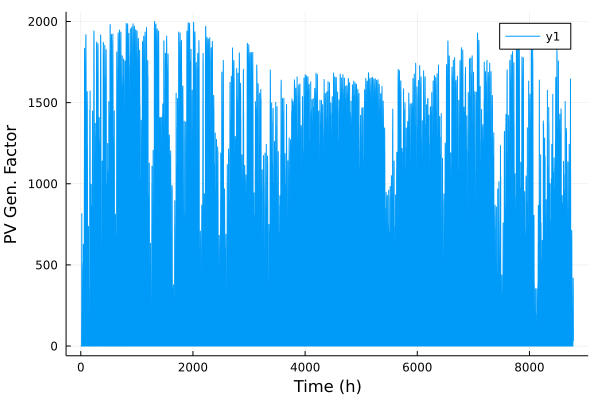

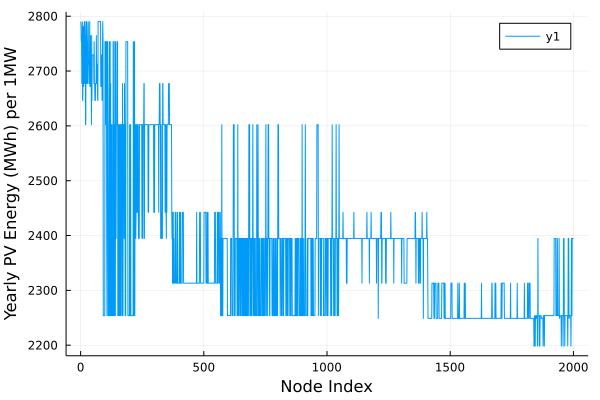

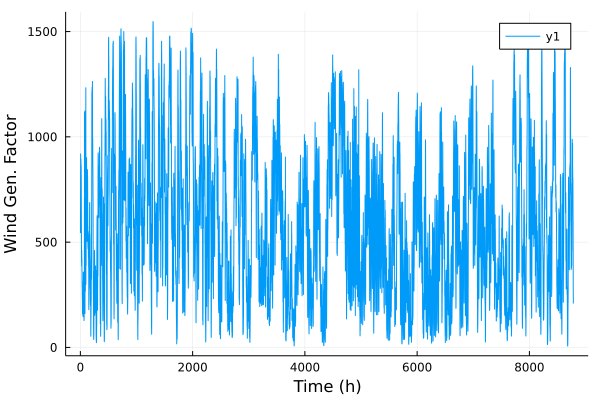

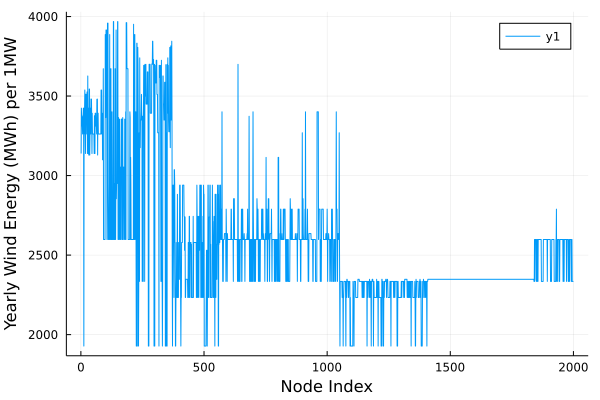

In [4]:
# nodal solar/wind max installation capacity
cap_sw_data = DataFrame(CSV.File("ERCOTSystem\\CPA_to_nodes.csv"))
cap_sw_data = coalesce.(cap_sw_data, 0.0)

# ------------------ Solar ------------------
solar_data = DataFrame(CSV.File("ERCOTSystem\\solars.csv"))
coe_PV_t_all = Matrix(solar_data[:,2:end])'/100    # unit: MW
coe_PV_t = coe_PV_t_all[:,T_sim]
# nodal total yearly solar coefficient 
coe_PV_all = sum(coe_PV_t_all, dims=2)

# plot solar power trajectories
f1pv = plot(sum(coe_PV_t_all, dims=1)',  xlabel = "Time (h)", ylabel = "PV Gen. Factor") #seriestype = :scatter,
f2pv = plot(coe_PV_all, xlabel = "Node Index", ylabel = "Yearly PV Energy (MWh) per 1MW")
display(f1pv)
display(f2pv)
#display(plot(f1pv, f2pv, layout = (1, 2), legend = false))

# Nodal Maximum Installation Capacity
# cap_PV_max = 2000 # unit: MW
# cd_PV_flag = (coe_PV_all .>= 0)  # =1: installation candidate, =0: not
# cap_PV = cap_PV_max*cd_PV_flag
# cap_PV = cap_PV[:,1]
# print("The PV installation candidate node number is ", sum(cd_PV_flag), "\n")
cap_PV = cap_sw_data[:,2] # unit: MW

# ------------------ Wind ------------------
wind_data = DataFrame(CSV.File("ERCOTSystem\\winds.csv"))
coe_WD_t_all = Matrix(wind_data[:,2:end])'/100    # unit: MW
coe_WD_t = coe_WD_t_all[:,T_sim]
# nodal total yearly wind coefficient
coe_WD_all = sum(coe_WD_t_all, dims=2)

# plot wind power trajectories
f1wd = plot(sum(coe_WD_t_all, dims = 1)', xlabel = "Time (h)", ylabel = "Wind Gen. Factor")# seriestype = :scatter,
f2wd = plot(coe_WD_all, xlabel = "Node Index", ylabel = "Yearly Wind Energy (MWh) per 1MW")
#display(plot(f1wd, f2wd, layout = (1, 2), legend = false))
display(f1wd)
display(f2wd)

# Nodal Maximum Installation Capacity
# cap_WD_max = 2000 # unit: MW
# cd_WD_flag = (coe_WD_all .>= 250)  # =1: installation candidate, =0: not
# cap_WD = cap_WD_max*cd_WD_flag
# cap_WD = cap_WD[:,1]
# print("The WD installation candidate node number is ", sum(cd_WD_flag))
cap_WD = cap_sw_data[:,3];

In [15]:
coe_WD_t_all

2000×8784 Matrix{Float64}:
 0.45  0.52  0.59  0.51  0.45  0.54  …  0.44  0.39  0.31  0.21  0.13  0.19
 0.26  0.18  0.2   0.18  0.29  0.29     0.08  0.07  0.02  0.05  0.04  0.01
 0.49  0.59  0.61  0.61  0.61  0.6      0.27  0.18  0.14  0.26  0.22  0.22
 0.49  0.59  0.61  0.61  0.61  0.6      0.27  0.18  0.14  0.26  0.22  0.22
 0.55  0.59  0.63  0.52  0.47  0.59     0.36  0.31  0.35  0.27  0.17  0.09
 0.55  0.59  0.63  0.52  0.47  0.59  …  0.36  0.31  0.35  0.27  0.17  0.09
 0.63  0.58  0.6   0.65  0.64  0.65     0.2   0.38  0.44  0.59  0.53  0.57
 0.45  0.32  0.33  0.26  0.33  0.42     0.01  0.03  0.02  0.05  0.03  0.0
 0.45  0.32  0.33  0.26  0.33  0.42     0.01  0.03  0.02  0.05  0.03  0.0
 0.26  0.18  0.2   0.18  0.29  0.29     0.08  0.07  0.02  0.05  0.04  0.01
 0.26  0.18  0.2   0.18  0.29  0.29  …  0.08  0.07  0.02  0.05  0.04  0.01
 0.0   0.0   0.02  0.05  0.27  0.21     0.0   0.01  0.0   0.0   0.0   0.0
 0.63  0.58  0.6   0.65  0.64  0.65     0.2   0.38  0.44  0.59  0.53  0.57
 

In [30]:
# ============= Select K typical days by K-means clustering ===========
using Clustering

# convert data by days
num_day = Int(num_time/24)  # 366 days

coe_WD_day_all = zeros(num_bus*24,num_day)
coe_PV_day_all = zeros(num_bus*24,num_day)
p_load_day_all = zeros(num_bus*24,num_day)
for i = 1:num_day
   coe_WD_day_all[:,i] = vec(coe_WD_t_all[:,24*i-23:24*i]);
   coe_PV_day_all[:,i] = vec(coe_PV_t_all[:,24*i-23:24*i]);
   p_load_day_all[:,i] = vec(p_load_t_all[:,24*i-23:24*i]);  
end

#p_load_day_all_nor = abs.(p_load_day_all)./(maximum(abs.(p_load_day_all), dims = 2).+1e-8)

feature_day = vcat(p_load_day_all, coe_WD_day_all, coe_PV_day_all)

144000×366 Matrix{Float64}:
 34.57  34.86  34.0   30.65  32.49  …  33.69  34.18  34.18  36.39  36.96
 25.64  25.86  25.21  22.73  24.09     24.98  25.35  25.34  26.99  27.41
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0    0.0
 11.66  11.76  11.47  10.34  10.96     11.36  11.53  11.53  12.28  12.47
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0    0.0
  4.97   5.01   4.88   4.41   4.68      4.84   4.92   4.92   5.24   5.32
 48.63  49.04  47.82  43.11  45.7      47.39  48.08  48.07  51.19  51.99
  ⋮                            

In [100]:
K_day = 6
cluster_days = kmeans(feature_day, K_day; maxiter=500, display=:iter)
typical_days = cluster_days.centers; # get the cluster centers
Assign_day = assignments(cluster_days) # get the assignments of points to clusters
Count_day = counts(cluster_days) # number of points in each cluster

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.768959e+08
      1       1.413164e+08      -1.355795e+08 |        6
      2       1.401384e+08      -1.178027e+06 |        5
      3       1.396028e+08      -5.356038e+05 |        3
      4       1.390209e+08      -5.819131e+05 |        3
      5       1.383866e+08      -6.342354e+05 |        4
      6       1.376271e+08      -7.595466e+05 |        4
      7       1.369400e+08      -6.870761e+05 |        4
      8       1.364266e+08      -5.133962e+05 |        2
      9       1.364014e+08      -2.516980e+04 |        2
     10       1.363967e+08      -4.743970e+03 |        0
     11       1.363967e+08       0.000000e+00 |        0
K-means converged with 11 iterations (objv = 1.3639668748600024e8)


6-element Vector{Int64}:
 56
 75
 61
 57
 54
 63

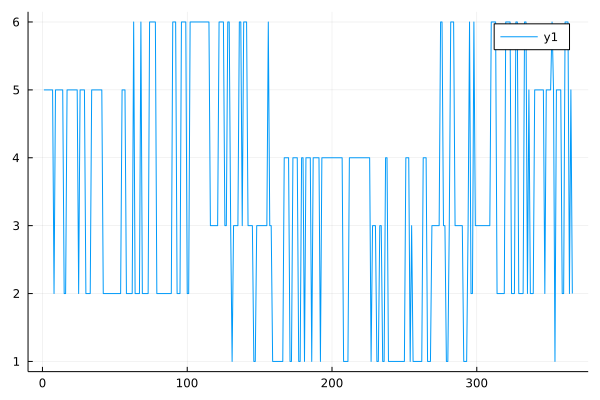

In [101]:
plot(Assign_day)

Peak Load is 57419.895 (MW)
Peak Load is 35636.689 (MW)
Peak Load is 48443.619 (MW)
Peak Load is 64784.521 (MW)
Peak Load is 42237.564 (MW)
Peak Load is 39849.643 (MW)


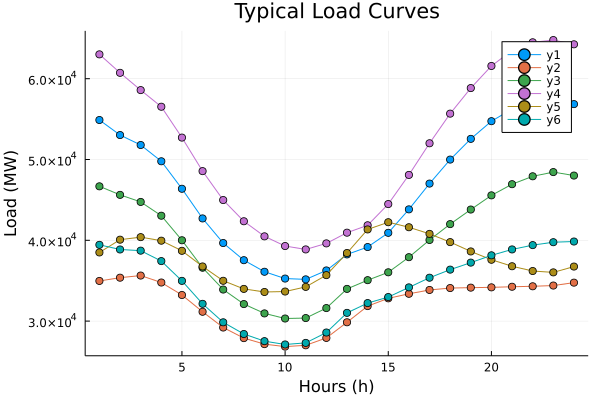

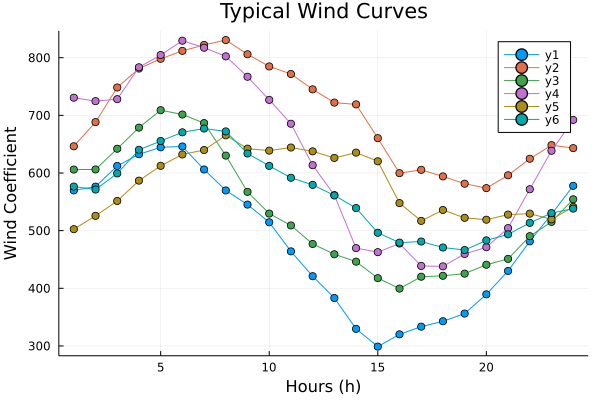

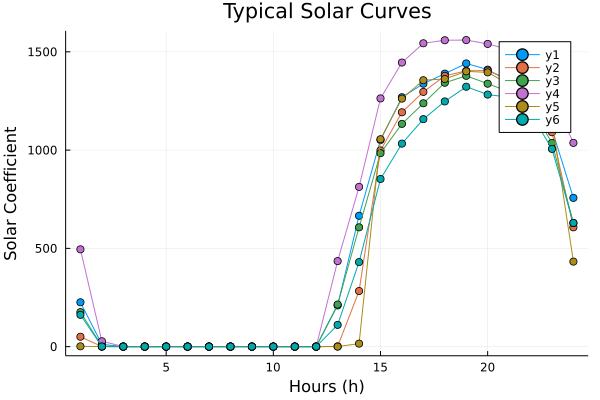

Total power plants number is 598
Power plant types include String7["wind", "solar", "ng", "coal", "hydro", "nuclear"]
solar: 2460.2 MW (2.229%) 
wind: 19062.63 MW (17.273%) 
natural gas: 68642.42 MW (62.198%) 
coal: 14501.59 MW (13.14%) 
hydro: 555.1 MW (0.503%) 
nuclear: 5138.6 MW (4.656%) 
clean energy: 27216.53 MW (24.661%) 
total: 110360.54 MW 


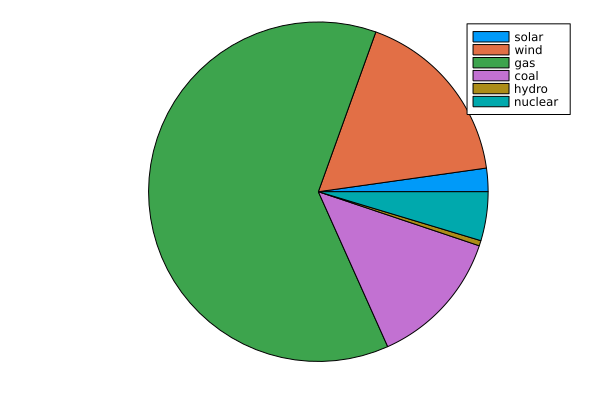

In [5]:
# ------------------ All Existing Power Plants ------------------
plant_data = DataFrame(CSV.File("ERCOTSystem\\texas_plant.csv"))
num_plant = size(plant_data, 1)
plant_data.rowindex = 1:num_plant  # add a row order index
print("Total power plants number is ", num_plant, "\n")

print("Power plant types include ", unique(plant_data.type),"\n")
plant_data_solar = plant_data[ plant_data.type .== "solar", :]
plant_data_wind = plant_data[ plant_data.type .== "wind", :]
plant_data_ng = plant_data[ plant_data.type .== "ng", :] 
plant_data_coal = plant_data[ plant_data.type .== "coal", :]
plant_data_hydro = plant_data[ plant_data.type .== "hydro", :] 
plant_data_nuclear = plant_data[ plant_data.type .== "nuclear", :] 

#pg_solar = sum(plant_data_solar.Pg)
#pg_wind = sum(plant_data_wind.Pg)
#pg_ng = sum(plant_data_ng.Pg)
#pg_coal = sum(plant_data_coal.Pg)
#pg_hydro = sum(plant_data_hydro.Pg)
#pg_nuclear = sum(plant_data_nuclear.Pg)
#pg_sum = sum(plant_data.Pg)
                            
pg_solar = sum(plant_data_solar.Pmax)
pg_wind = sum(plant_data_wind.Pmax)
pg_ng = sum(plant_data_ng.Pmax)
pg_coal = sum(plant_data_coal.Pmax)
pg_hydro = sum(plant_data_hydro.Pmax)
pg_nuclear = sum(plant_data_nuclear.Pmax)
pg_sum = sum(plant_data.Pmax)

labels = ["solar"; "wind"; "gas";"coal"; "hydro"; "nuclear"] 
sizes = [pg_solar; pg_wind; pg_ng; pg_coal; pg_hydro; pg_nuclear]
print("solar: ", round(pg_solar, digits =3), " MW (", round(pg_solar/pg_sum*100, digits =3), "%) \n", 
      "wind: ", round(pg_wind, digits =3), " MW (", round(pg_wind/pg_sum*100, digits =3), "%) \n", 
      "natural gas: ", round(pg_ng, digits =3), " MW (", round(pg_ng/pg_sum*100, digits =3), "%) \n", 
      "coal: ",  round(pg_coal, digits =3), " MW (", round(pg_coal/pg_sum*100, digits =3), "%) \n", 
      "hydro: ",  round(pg_hydro, digits =3), " MW (", round(pg_hydro/pg_sum*100, digits =3), "%) \n", 
      "nuclear: ",  round(pg_nuclear, digits =3), " MW (", round(pg_nuclear/pg_sum*100, digits =3), "%) \n", 
      "clean energy: ",  round(pg_nuclear+pg_solar+pg_wind+pg_hydro, digits =3), " MW (", round((pg_nuclear+pg_solar+pg_wind+pg_hydro)/pg_sum*100, digits =3), "%) \n", 
      "total: ", round(pg_sum, digits =3), " MW \n")

#pie(labels, sizes)
plot(labels, sizes,seriestype = :pie )

In [6]:
# ----------------- Parameters for Existing Power Plants -----------
num_gen_ng      = size(plant_data_ng,1)
num_gen_coal    = size(plant_data_coal,1)
num_gen_solar   = size(plant_data_solar,1)
num_gen_wind    = size(plant_data_wind,1)
num_gen_hydro   = size(plant_data_hydro,1)
num_gen_nuclear = size(plant_data_nuclear,1)

# generation capacity over time
Pmin_ng = plant_data_ng.Pmin.*ones(1,num_time_sim)
Pmax_ng = plant_data_ng.Pmax.*ones(1,num_time_sim)
ramp_ng_max = dt*2*plant_data_ng.ramp_30
ramp_ng_min = - ramp_ng_max 

Pmin_coal = plant_data_coal.Pmin.*ones(1,num_time_sim)
Pmax_coal = plant_data_coal.Pmax.*ones(1,num_time_sim)
ramp_coal_max = dt*2*plant_data_coal.ramp_30
ramp_coal_min = - ramp_coal_max 

# Construct nodal matrices for power flow
A_coal = zeros(num_bus,num_gen_coal)
A_ng = zeros(num_bus,num_gen_ng)
A_wind = zeros(num_bus,num_gen_wind)
A_solar = zeros(num_bus,num_gen_solar)
A_nuclear = zeros(num_bus,num_gen_nuclear)

for i = 1:num_gen_coal
    bus_index = bus_data[bus_data.bus_id .== plant_data_coal[i,:].bus_id, :].rowindex[1]
    A_coal[bus_index, i] = 1
end

for i = 1:num_gen_ng
    bus_index = bus_data[bus_data.bus_id .== plant_data_ng[i,:].bus_id, :].rowindex[1]
    A_ng[bus_index, i] = 1
end

for i = 1:num_gen_nuclear
    bus_index = bus_data[bus_data.bus_id .== plant_data_nuclear[i,:].bus_id, :].rowindex[1]
    A_nuclear[bus_index, i] = 1
end
P_nuclear = plant_data_nuclear.Pg.*ones(1,num_time_sim)

solar_index = Int32.(zeros(num_gen_solar,1))
for i =1: num_gen_solar
    bus_index = bus_data[bus_data.bus_id .== plant_data_solar[i,:].bus_id, :].rowindex[1]
    A_solar[bus_index, i] = 1
    solar_index[i] = bus_index
end
Pmax_solar = plant_data_solar.Pmax.*coe_PV_t[solar_index[:,1], :]

wind_index = Int32.(zeros(num_gen_wind,1))
for i =1: num_gen_wind
    bus_index = bus_data[bus_data.bus_id .== plant_data_wind[i,:].bus_id, :].rowindex[1]
    A_wind[bus_index, i] = 1
    wind_index[i] = bus_index 
end
Pmax_wind = plant_data_wind.Pmax.*coe_WD_t[wind_index[:,1], :];

# Energy Storage 
cap_ES_max = 20000 # MWh
cap_ES = cap_ES_max*ones(num_bus,1)[:,1]
#cap_ES[800:end] .= 0
 
p_dis_max = 0.25 # MW
p_cha_max = 0.25 # MW
e_max = 1  #MWh
ES_ini = 0.5  # initial SOC is 50%
kap_ES = 0.99 # 100% no leakage

alp_cha = sqrt(0.85)
alp_dis = sqrt(0.85)

# Cost parameters
gencost_data = DataFrame(CSV.File("ERCOTSystem\\texas_gencost.csv"))

c_gen_ng = hcat(gencost_data[plant_data_ng.rowindex,:].c2, 
                gencost_data[plant_data_ng.rowindex,:].c1, 
                gencost_data[plant_data_ng.rowindex,:].c0)/1e3 

c_gen_coal = hcat(gencost_data[plant_data_coal.rowindex,:].c2, 
                  gencost_data[plant_data_coal.rowindex,:].c1, 
                  gencost_data[plant_data_coal.rowindex,:].c0)/1e3  

#c1 $/MWh
#c0 $/h

# investment
c_PV_invest = 890 # k$/MW
c_WD_invest = 1212 # k$/MW
c_ES_invest = 369 # k$/MWh
c_curtail = 0.002 # k$/MWh
c_ES_oper = 0.001  # k$/MWh
c_loadshed = 5  # k$/MWh
c_coal_retire = 117 # k$/MW
c_ng_retire = 15 # k$/MW

15

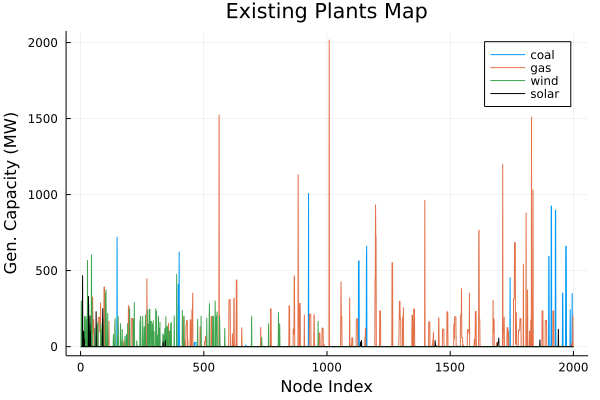

In [7]:
# Existing Nodal Capacity of Generation Disrribution
nc_coal = A_coal*Pmax_coal[:,1]
nc_ng = A_ng*Pmax_ng[:,1]
nc_wind = A_wind*plant_data_wind.Pmax
nc_solar = A_solar*plant_data_solar.Pmax;

plot(nc_coal, label = "coal")
plot!(nc_ng, label= "gas")
plot!(nc_wind, label= "wind")
plot!(nc_solar, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (MW)", linecolor = "black", title = "Existing Plants Map")

# 3- Optimal Planning Model

In [8]:
## ================= Select Optimizer =====================
model_plan = Model(Gurobi.Optimizer)
# model_plan = Model(Ipopt.Optimizer)
#model_plan = Model(CPLEX.Optimizer)
#set_optimizer_attribute(model_plan, "output_flag", true)
#set_optimizer_attribute(model_plan, "Method", 1) #use dual simplex


## ================= Create Variables and Constraints =====================
# Solar  
@variable(model_plan, 0 <= w_PV_var[1:num_bus])
@variable(model_plan, 0 <= p_PV_var[1:num_bus, 1:num_time_sim])
@constraint(model_plan, w_PV_var .<= cap_PV)
@constraint(model_plan, p_PV_var .<= w_PV_var.*coe_PV_t)

# Wind  
@variable(model_plan, 0 <= w_WD_var[1:num_bus])
@variable(model_plan, 0 <= p_WD_var[1:num_bus, 1:num_time_sim])
@constraint(model_plan, w_WD_var .<= cap_WD)
@constraint(model_plan, p_WD_var .<= w_WD_var.*coe_WD_t)

# Existing Solar and Wind
@variable(model_plan, 0 <= p_solar_var[1:num_gen_solar, 1:num_time_sim]) # solar
@variable(model_plan, 0 <= p_wind_var[1:num_gen_wind, 1:num_time_sim]) # wind
@constraint(model_plan, p_wind_var .<= Pmax_wind)
@constraint(model_plan, p_solar_var .<= Pmax_solar)


# Coal Generators
#@variable(model_plan, z_coal_var[1:num_gen_coal], Bin) # coal
@variable(model_plan, 0 <= z_coal_var[1:num_gen_coal] <= 1) # coal
@variable(model_plan, p_coal_var[1:num_gen_coal, 1:num_time_sim])
@constraint(model_plan, z_coal_var.*Pmin_coal .<= p_coal_var)
@constraint(model_plan, p_coal_var .<= z_coal_var.*Pmax_coal)
for t = 2:num_time_sim
   @constraint(model_plan,  ramp_coal_min .<= p_coal_var[:,t] - p_coal_var[:,t-1] .<= ramp_coal_max )
end

# Natural Gass
#@variable(model_plan, z_ng_var[1:num_gen_ng], Bin) # natural gas
@variable(model_plan, 0 <= z_ng_var[1:num_gen_ng] <= 1) # natural gas
@variable(model_plan, p_ng_var[1:num_gen_ng, 1:num_time_sim])

@constraint(model_plan, z_ng_var.*Pmin_ng .<= p_ng_var)
@constraint(model_plan, p_ng_var .<= z_ng_var.*Pmax_ng);
for t = 2:num_time_sim
   @constraint(model_plan,  ramp_ng_min .<= p_ng_var[:,t] - p_ng_var[:,t-1] .<= ramp_ng_max )
end


# Adjustable Loads
#@variable(model_plan, 0 <= p_load_var[1:num_load, 1:num_time_sim])
#@constraint(model_plan, p_load_min_t .<= p_load_var .<= p_load_max_t)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31


In [9]:
##  Energy Storage
alp_cha = 1
alp_dis = 1

# --------------------------- full model ------------------------
# @variable(model_plan, nu_ES_var[1:num_bus, 1:num_time_sim], Bin)
@variable(model_plan, 0 <= nu_ES_var[1:num_bus, 1:num_time_sim] <= 1)
@variable(model_plan, 0 <= w_ES_var[1:num_bus])
@variable(model_plan, 0 <= y_ES_var[1:num_bus, 1:num_time_sim] )
@variable(model_plan, 0 <= p_dis_var[1:num_bus, 1:num_time_sim])
@variable(model_plan, 0 <= p_cha_var[1:num_bus, 1:num_time_sim])
@variable(model_plan, 0 <= e_ES_var[1:num_bus, 1:num_time_sim])

big_M = 1e3
@constraint(model_plan, w_ES_var .<= cap_ES)
@constraint(model_plan, p_dis_var .<= p_dis_max*y_ES_var )
@constraint(model_plan, p_cha_var .<= p_cha_max*( w_ES_var*ones(1,num_time_sim) - y_ES_var))
@constraint(model_plan, y_ES_var .<= w_ES_var*ones(1,num_time_sim)) 
@constraint(model_plan, y_ES_var .<= big_M*nu_ES_var)

for t = 1:num_time_sim
    @constraint(model_plan, big_M*nu_ES_var[:,t] - big_M*ones(num_bus,1) + w_ES_var .<= y_ES_var[:,t])
    if t == 1
        @constraint(model_plan, e_ES_var[:,t] .== kap_ES*(ES_ini*e_max*w_ES_var) + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
    else
        @constraint(model_plan, e_ES_var[:,t] .== kap_ES*e_ES_var[:,t-1] + dt*(alp_cha*p_cha_var[:,t] - 1/alp_dis*p_dis_var[:,t]))
    end
    @constraint(model_plan, e_ES_var[:,t] .<= e_max*w_ES_var)
end
@constraint(model_plan, e_ES_var[:,num_time_sim] .== ES_ini*e_max*w_ES_var); # recover to the initial SOC

# ------------------------Simplified ES Model ------------------------

# @variable(model_plan, 0 <= w_ES_var[1:num_bus])
# @variable(model_plan,  p_ES_var[1:num_bus, 1:num_time_sim] )
# @variable(model_plan, 0 <= p_ES_abs_var[1:num_bus, 1:num_time_sim] )
# @variable(model_plan, 0 <= e_ES_var[1:num_bus, 1:num_time_sim])
# @constraint(model_plan, w_ES_var .<= cap_ES)
# @constraint(model_plan, p_ES_abs_var .>= p_ES_var)
# @constraint(model_plan, p_ES_abs_var .>= - p_ES_var)


# for t = 1:num_time_sim
#     @constraint(model_plan,  p_ES_var[:,t] .<= p_dis_max*w_ES_var )
#     @constraint(model_plan, - p_cha_max*w_ES_var .<= p_ES_var[:,t])
#      if t == 1
#          @constraint(model_plan, e_ES_var[:,t] .== kap_ES*(ES_ini*e_max*w_ES_var) - dt*p_ES_var[:,t] )
#      else
#          @constraint(model_plan, e_ES_var[:,t] .== kap_ES*e_ES_var[:,t-1] - dt*p_ES_var[:,t])
#      end
#      @constraint(model_plan, e_ES_var[:,t] .<= e_max*w_ES_var)
# end
# @constraint(model_plan, e_ES_var[:,num_time_sim] .== ES_ini*e_max*w_ES_var); # recover to the initial SOC

In [10]:
# # DC Power Flow
@variable(model_plan, P_br_var[1:num_branch, 1:num_time_sim])
@variable(model_plan, tha_var[1:(num_bus-1), 1:num_time_sim]);
# Power Flow
@constraint(model_plan, P_br_min .<= P_br_var .<= P_br_max)
@constraint(model_plan, P_br_var .== X_bn[:,2:end]*tha_var)
#@constraint(model_plan, tha_var[1,: ] .== zeros(num_time_sim,1)) # fix a slack phase angle
@constraint(model_plan, A_nb*P_br_var .== p_PV_var + p_WD_var + p_dis_var - p_cha_var - p_load_max_t #  p_load_var   # 
         + A_coal*p_coal_var + A_ng*p_ng_var + A_wind*p_wind_var + A_solar*p_solar_var + A_nuclear*P_nuclear);

# Reduced DC Power Flow
# # @variable(model_plan, P_br_var[1:num_branch, 1:num_time_sim])
# @variable(model_plan, tha_var[1:(num_bus-1), 1:num_time_sim]);
# X_bn_redu = X_bn[:,2:end]
# AX_com = A_nb*X_bn_redu;
# # Power Flow
# @constraint(model_plan, X_bn_redu*tha_var .<= P_br_max )
# @constraint(model_plan, P_br_min .<= X_bn_redu*tha_var )
# #@constraint(model_plan, tha_var[1,: ] .== zeros(num_time_sim,1)) # fix a slack phase angle
# @constraint(model_plan, AX_com*tha_var .== p_PV_var + p_WD_var + p_ES_var - p_load_max_t #  p_load_var   # 
#          + A_coal*p_coal_var + A_ng*p_ng_var + A_wind*p_wind_var + A_solar*p_solar_var + A_nuclear*P_nuclear);

# Load Reliability
#for t = 1:num_time_sim
#    @constraint(model_plan, sum(p_load_max_t[:,t]- p_load_var[:,t]) <= L_shed_max_t[t] )
#end  
#@constraint(model_plan, sum(p_load_max_t) - sum(p_load_var) <= L_shed_max) 

   
# Renewable Penetration
renew_pene = 0.8
@constraint(model_plan, sum(p_coal_var) + sum(p_ng_var) <= (1 - renew_pene)*sum(p_load_max_t));
#@constraint(model_plan, sum(w_PV_var + w_WD_var) + sum() >= gam_C*sum(z_gen_var.*cap_gen) )

In [33]:
## ================= Define Objective =====================
num_years = 10*365

Obj_invest = 1/num_years*(sum(c_PV_invest*w_PV_var) +  sum(c_WD_invest*w_WD_var) + sum(c_ES_invest*w_ES_var))

Obj_opera =  c_curtail*(sum( w_PV_var.*coe_PV_t - p_PV_var) + sum( w_WD_var.*coe_WD_t - p_WD_var)
               + sum(Pmax_wind - p_wind_var) + sum(Pmax_solar-p_solar_var))
              # + c_ES_oper*sum(p_ES_abs_var)  #
               + c_ES_oper*sum(p_dis_var + p_cha_var)
         # + c_loadshed*sum(p_load_max_t - p_load_var)
        #  + sum(c_coal_retire*(ones(num_gen_coal,1)-z_coal_var)) 
        #  + sum(c_ng_retire*(ones(num_gen_ng,1)-z_ng_var)) 

#Obj_exp = 0
         
for i = 1:num_gen_coal
    Obj_opera =  Obj_opera + sum(c_gen_coal[i,2]*p_coal_var[i,:]
                       + z_coal_var[i]*c_gen_coal[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_coal[i,1]*(p_coal_var[i,:].^2) )
end

for i = 1:num_gen_ng
    Obj_opera =  Obj_opera + sum( c_gen_ng[i,2]*p_ng_var[i,:]
                       + z_ng_var[i]*c_gen_ng[i,3]*ones(num_time_sim,1))
                       + sum(c_gen_ng[i,1]*(p_ng_var[i,:].^2))
end

Obj_exp = Obj_invest + Obj_opera

@objective(model_plan, Min, Obj_exp);

In [ ]:
## ================= Solve model =======================
tick()
optimize!(model_plan)
tock()

solar: 7704.561 MWh (1.119%) 
wind: 82603.896 MWh (11.996%) 
natural gas: 391823.806 MWh (56.902%) 
coal: 148433.178 MWh (21.556%) 
nuclear: 58031.88 MWh (8.428%) 
clean energy: 148340.336 MWh (21.542%) 
total generation: 688597.32 MWh 
total load: 688597.32 MWh 


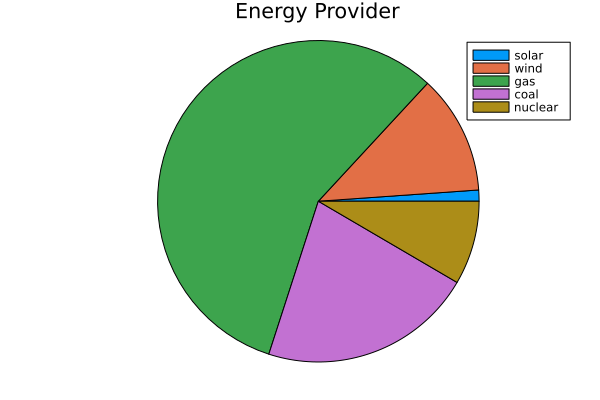

In [35]:
## ================= Show Results =======================
# Solar Power 
p_PV = value.(p_PV_var)
p_solar = value.(p_solar_var)
p_WD = value.(p_WD_var)
p_wind = value.(p_wind_var)
p_coal = value.(p_coal_var)
p_ng = value.(p_ng_var)
#p_load = value.(p_load_var)
p_load = p_load_max_t

# 
E_solar = sum(p_PV) + sum(p_solar)
E_wind = sum(p_WD) + sum(p_wind)
E_coal = sum(p_coal)
E_ng = sum(p_ng)
E_nuclear = sum(P_nuclear)
E_gen = E_solar + E_wind + E_coal + E_ng + E_nuclear
E_load = sum(p_load)

labels = ["solar"; "wind"; "gas";"coal"; "nuclear"] 
sizes = [E_solar; E_wind; E_ng; E_coal; E_nuclear]
print("solar: ", round(E_solar, digits =3), " MWh (", round(E_solar/E_gen*100, digits =3), "%) \n", 
      "wind: ", round(E_wind, digits =3), " MWh (", round(E_wind/E_gen*100, digits =3), "%) \n", 
      "natural gas: ", round(E_ng, digits =3), " MWh (", round(E_ng/E_gen*100, digits =3), "%) \n", 
      "coal: ",  round(E_coal, digits =3), " MWh (", round(E_coal/E_gen*100, digits =3), "%) \n", 
      "nuclear: ",  round(E_nuclear, digits =3), " MWh (", round(E_nuclear/E_gen*100, digits =3), "%) \n", 
      "clean energy: ",  round(E_nuclear+E_solar+E_wind, digits =3), " MWh (", round((E_nuclear+E_solar+E_wind)/E_gen*100, digits =3), "%) \n", 
      "total generation: ", round(E_gen, digits =3), " MWh \n",
      "total load: ", round(E_load, digits =3), " MWh \n")

#pie(labels, sizes)
plot(labels, sizes,seriestype = :pie, title = "Energy Provider" )



Total solar installation cap: 0.078 (GW)
Total wind installation cap: 0.0 (GW)
Total energy storage installation cap: 0.0 (GWh)


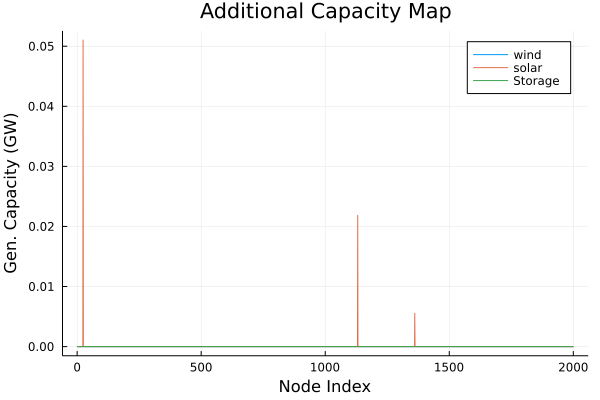

The objective (total cost) is 14826.226 
Investment Cost: 0.07 billion $
Solar Investment Cost: 0.07 billion $
Wind Investment Cost: 0.0 billion $
Storage Investment Cost: 0.0 billion $
Operational Cost: 14807.108 k$


In [36]:
# Planned Nodal Capacity of Generation Disrribution
w_PV = value.(w_PV_var)
w_WD = value.(w_WD_var)
w_ES = value.(w_ES_var)
print("Total solar installation cap: ", round(sum(w_PV)/1e3, digits =3)," (GW)\n")
print("Total wind installation cap: ", round(sum(w_WD)/1e3, digits =3)," (GW)\n")
print("Total energy storage installation cap: ", round(sum(w_ES)/1e3, digits =3)," (GWh)\n")

figr = plot(w_WD/1e3, label= "wind")
figr = plot!(w_PV/1e3, label= "solar", xlabel = "Node Index", ylabel = "Gen. Capacity (GW)",  title = "Additional Capacity Map")
figr = plot!(w_ES/1e3, label= "Storage")
display(figr)

# Output Solutions
print("The objective (total cost) is ", round(objective_value(model_plan),digits =3)," \n")
print("Investment Cost: ", round(num_years*value(Obj_invest)/1e6,digits =3), " billion \$\n")
print("Solar Investment Cost: ", round(sum(c_PV_invest*(w_PV))/1e6,digits =3), " billion \$\n")
print("Wind Investment Cost: ", round(sum(c_WD_invest*w_WD)/1e6,digits =3), " billion \$\n")
print("Storage Investment Cost: ", round(sum(c_ES_invest*w_ES)/1e6,digits =3), " billion \$\n")
print("Operational Cost: ", round(value(Obj_opera),digits =3), " k\$\n")

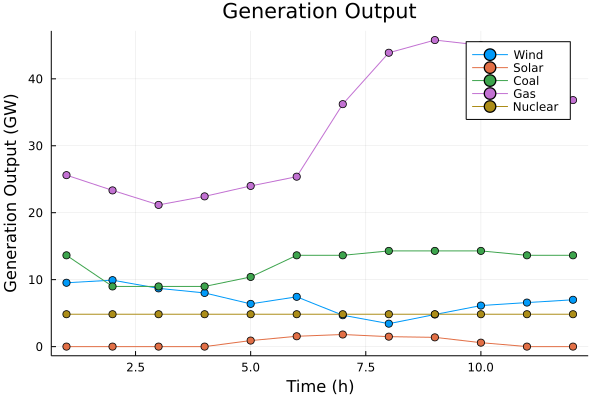

In [37]:
P_solar_t = sum(p_PV, dims=1)+sum(p_solar, dims=1)
P_solar_t = P_solar_t'[:,1]

P_wind_t = sum(p_wind, dims=1)+sum(p_WD, dims=1)
P_wind_t = P_wind_t'[:,1]

P_coal_t = sum(p_coal, dims =1)
P_coal_t = P_coal_t'[:,1]

P_ng_t = sum(p_ng, dims =1)
P_ng_t = P_ng_t'[:,1]

P_nuclear_t = sum(P_nuclear, dims =1)
P_nuclear_t = P_nuclear_t'[:,1]



plot(P_wind_t/1e3, markershape =:circle, title = "Generation Output", label = "Wind", lw = 1)
plot!(P_solar_t/1e3, markershape =:circle, title = "Generation Output", label = "Solar", lw = 1)
plot!(P_coal_t/1e3, markershape =:circle, title = "Generation Output", label = "Coal", lw = 1)
plot!(P_ng_t/1e3, markershape =:circle, title = "Generation Output", label = "Gas", lw = 1)
plot!(P_nuclear_t/1e3, markershape =:circle, title = "Generation Output", label = "Nuclear", xlabel = "Time (h)", ylabel = "Generation Output (GW)", lw = 1)

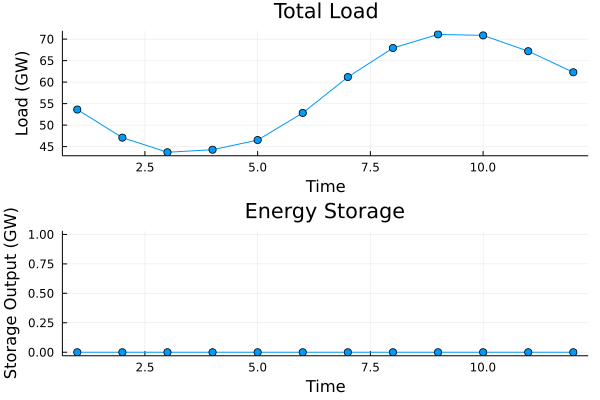

In [38]:
# Load
P_load_t = sum(value.(p_load_max_t), dims = 1)
r1fig = plot(P_load_t'/1e3, markershape =:circle, xlabel = "Time", ylabel = "Load (GW)", title = "Total Load")

# Energy Storage
# p_ES_t = sum(value.(p_ES_var), dims = 1)
p_ES_t = sum(value.(p_cha_var + p_dis_var), dims = 1)
r2fig = plot(p_ES_t'/1e3,  xlabel = "Time", ylabel = "Storage Output (GW)", title = "Energy Storage", markershape =:circle)

display(plot(r1fig, r2fig, layout = (2, 1), legend = false))